In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import ConvexHull
from scipy.signal import savgol_filter
import plotly.express as px

import sys

sys.path.append("../components/paddock/")

%load_ext autoreload
%autoreload 2
from telemetry.influx import Influx

from IPython.display import Image

import plotly.express as px
import plotly.graph_objects as go

pd.set_option("display.max_columns", None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
influx = Influx()
influx.laps_from_file("tracks.csv")
# data = influx.telemetry_for(game = "Automobilista 2", track = "Nurburgring_2020:Nurb_GP_2020_Veedol")
# data = influx.telemetry_for(game = "Automobilista 2", track = "SpaFrancorchamps:Spa_Francorchamps_1970")
data = influx.telemetry_for(
    game="Automobilista 2", track="Laguna_Seca:Laguna_Seca_2020"
)
# data = influx.telemetry_for(game = "Automobilista 2", track = "Fontana:Fontana_OVAL")

Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670176288 5
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670176288 4
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670176288 1
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670176288 3
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670176288 2
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 11
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 4
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 3
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 13
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 5
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 2
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 6
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 8
Processing Automobilista 2 Laguna_Seca:Laguna_Seca_2020 1670260618 12
Processing Automobilista 2 Lagu

In [29]:
f = go.FigureWidget()
display(f)

for idx, df in enumerate(data):
    # df.plot.scatter(x="x", y="y", s=0.1)
    # plt.show()
    f.add_scatter(
        x=df["x"], y=df["y"], name=str(idx), mode="markers", marker=dict(size=2)
    )

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

## Preprocessing data

1. Some dataframes contains multiple laps. These multiple laps need to be split single laps.
2. In some laps vehicle goes out the track and driver goes revers. Driving reverse parts can be cleaned from data.

In [20]:
f = go.FigureWidget()
display(f)

# Convert df data to numpy arrays
points_a = []
distances_a = []
for idx, df in enumerate(data):
    distances = df[["DistanceRoundTrack"]].to_numpy()[:, 0]
    points = df[["x", "y"]].to_numpy()
    distances, points = influx.make_monotonic(distances, points)

    points_a.append(points)
    distances_a.append(distances)

    f.add_scatter(y=distances, name=str(idx), mode="markers", marker=dict(size=2))

    # plt.plot(distances)
    # plt.xlabel('Index')
    # plt.ylabel('DistanceRoundTrack')
    # plt.show()

    # plt.figure()
    # x = points[:,0]
    # y = points[:,1]
    # plt.scatter(x, y, s=0.1)
    # plt.gca().set_aspect('equal', 'datalim')
    # plt.xlabel('WorldPosition_x')
    # plt.ylabel('WorldPosition_z')
    # plt.show()

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

## Creating track data
1. Track lenght is necessary for a better resampling. When car is slow, distance between the telementry messsage are very low.
2. All laps need to be resampled based on distance. This step is necessary for polynomial filter.
3. Outliers need to be filled with nan values. In laps, car slips and goes out the track. Around these extreme points data can be filled with nan.
4. Track points need to be created. A polynomial filter can be used to create track point.


### 1. Calculate track length

Track lenght is not available in the data. It can be calculated by using longest lap.

In [21]:
track_length = influx.track_length(distances_a)
track_length

3601.10864

### 2. Resample laps

Telemetry data is recorded based on time. When vehicle is driving slow, gets more sample from same position. These position need to be resampled

In [23]:
f = go.FigureWidget()
display(f)

for idx in range(len(distances_a)):
    distances_a[idx], points_a[idx] = influx.resample(
        distances_a[idx], points_a[idx], track_length
    )

    f.add_scatter(
        y=distances_a[idx], name=str(idx), mode="markers", marker=dict(size=2)
    )

    # plt.figure()
    # x = points_a[idx][:,0]
    # y = points_a[idx][:,1]
    # plt.scatter(x, y, s=0.1)
    # plt.gca().set_aspect('equal', 'datalim')
    # plt.xlabel('WorldPosition_x')
    # plt.ylabel('WorldPosition_z')
    # plt.show()

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

### 3. Fill with nan around outliers

Laps have some extream telemetry message. These outliers need to be filled with nan values. If yaw angle changes more than a threshold, this point is accepted as extreme

In [27]:
f = go.FigureWidget()
display(f)

for idx in range(len(distances_a)):
    points_a[idx] = influx.remove_outliers(points_a[idx])

    f.add_scatter(
        x=points_a[idx][:, 0],
        y=points_a[idx][:, 1],
        name=str(idx),
        mode="markers",
        marker=dict(size=2),
    )

    # plt.figure()
    # x = points_a[idx][:,0]
    # y = points_a[idx][:,1]
    # plt.scatter(x, y, s=0.1)
    # plt.gca().set_aspect('equal', 'datalim')
    # plt.xlabel('WorldPosition_x')
    # plt.ylabel('WorldPosition_z')
    # plt.show()

FigureWidget({
    'data': [], 'layout': {'template': '...'}
})

### 4. Calculate track points

There are records from multiple laps. These lap points need to be merge to a track points. A polynomial is fit around each points with multiple laps.

In [28]:
f = go.FigureWidget()
# display(f)

distances, points = influx.merge_track_points(distances_a, points_a, track_length)

f.add_scatter(
    x=points[:, 0], y=points[:, 1], name="merged", mode="markers", marker=dict(size=2)
)

# plt.figure()
# x = points[:,0]
# y = points[:,1]
# plt.scatter(x, y, s=0.1)
# plt.gca().set_aspect('equal', 'datalim')
# plt.xlabel('WorldPosition_x')
# plt.ylabel('WorldPosition_z')
# plt.show()

FigureWidget({
    'data': [{'marker': {'size': 2},
              'mode': 'markers',
              'name': 'me…

## Finding track corners
1. Yaw changes need to be calculated to detect corners. Yaw changes can be calculated by track points
2. Track sections need to be created. Track sections can be found by using yaw changes.
3. Visualize result.

### 1. Calculate yaw change

Yaw changes are need to find corners. From points yaw changes can be calculated by derivative.

### 2. Get track sections

Track sections need to be found. When yaw changes higher than the threshold, this point accepted as part of corner.

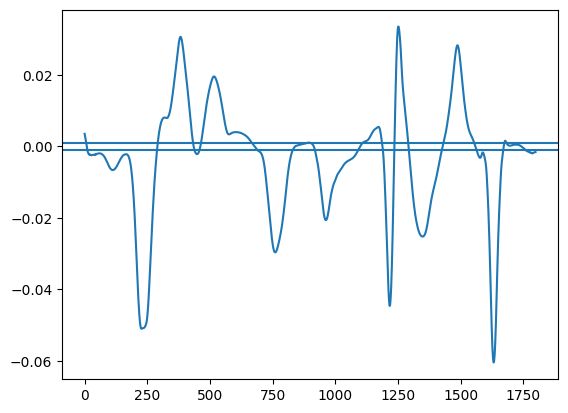

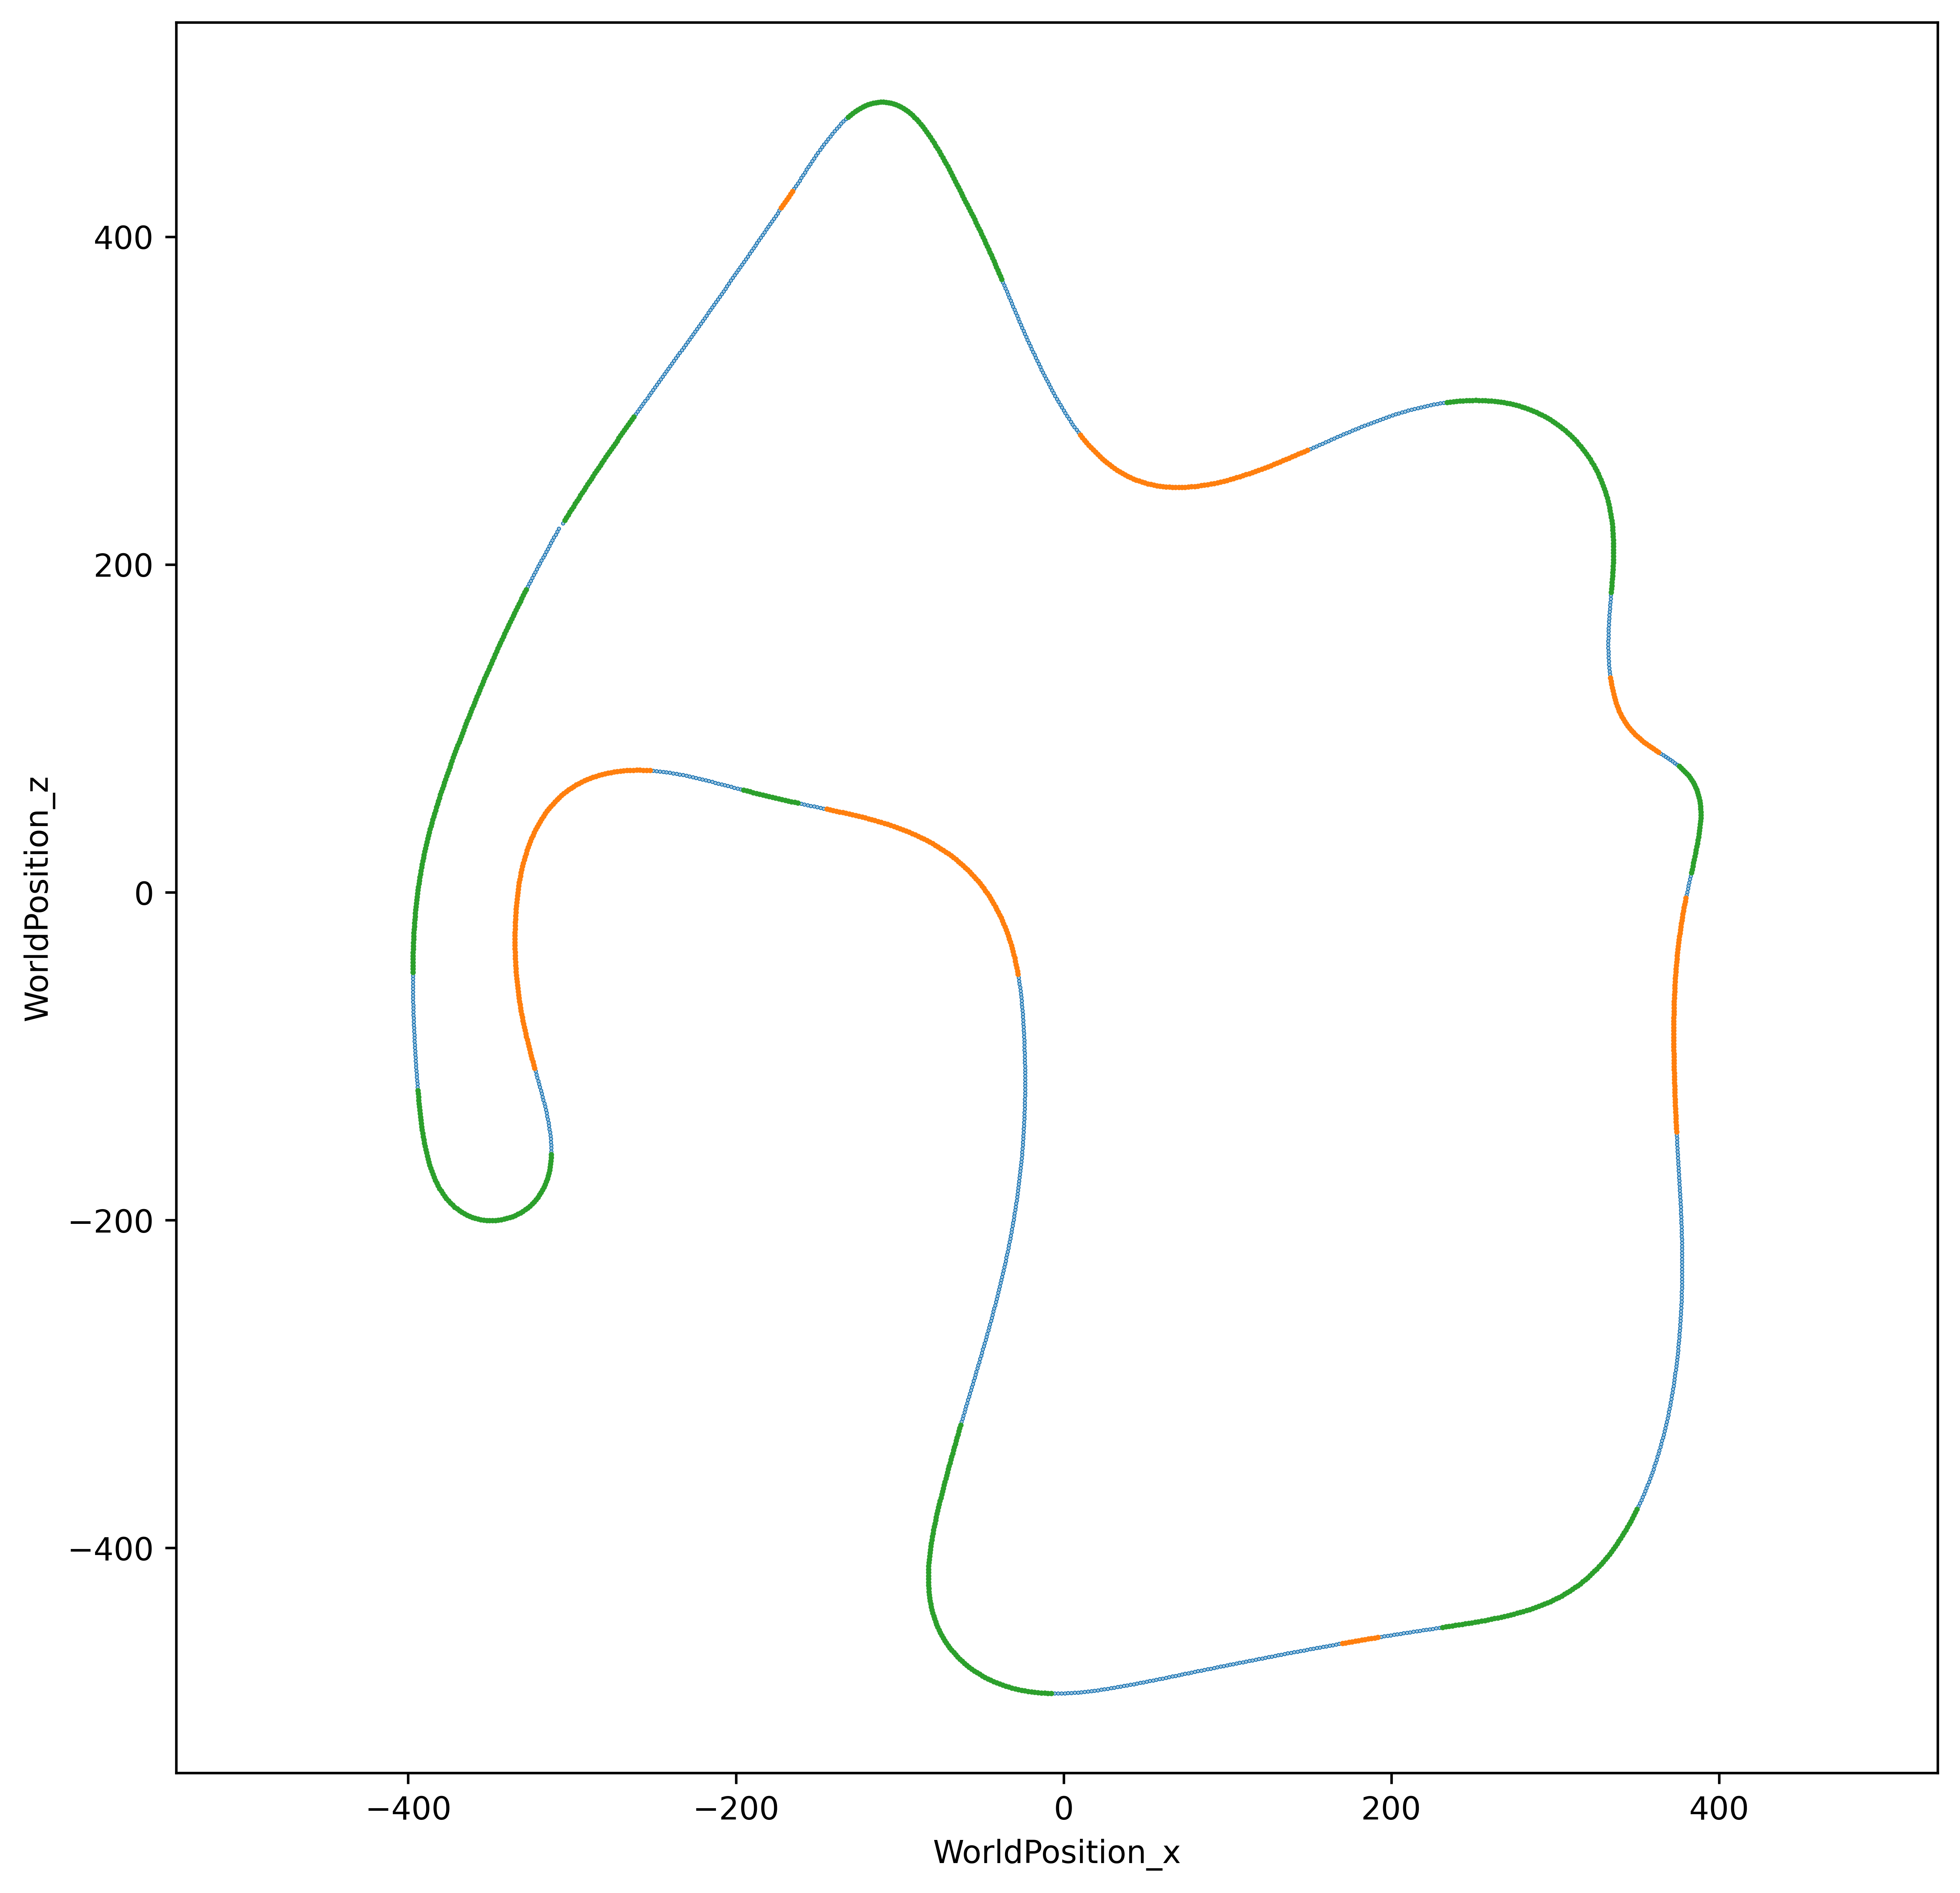

In [14]:
threshold = 0.001
yaw_changes = influx.yaw_changes(points)

plt.figure()
plt.plot(yaw_changes)
plt.axhline(y=-threshold, xmin=0, xmax=1)
plt.axhline(y=threshold, xmin=0, xmax=1)
plt.show()

sections = influx.track_sections(distances, yaw_changes, threshold=threshold)

straight = []
cw = []
ccw = []
# Iterate over points
for point_idx in range(distances.shape[0]):
    dist = distances[point_idx]
    # Iterate over sections
    for sec in sections:
        # Check if point is inside the sections.
        if sec["start"] < dist < sec["end"]:
            if sec["type"] == "straight":
                straight.append(points[point_idx])
            if sec["type"] == "clock_wise":
                cw.append(points[point_idx])
            if sec["type"] == "counter_clock_wise":
                ccw.append(points[point_idx])
straight = np.array(straight)
cw = np.array(cw)
ccw = np.array(ccw)

plt.figure(figsize=(10, 10), dpi=600)
plt.scatter(points[:, 0], points[:, 1], s=0.1)
if len(cw):
    plt.scatter(cw[:, 0], cw[:, 1], s=0.5)
if len(ccw):
    plt.scatter(ccw[:, 0], ccw[:, 1], s=0.5)
plt.gca().set_aspect("equal", "datalim")
plt.xlabel("WorldPosition_x")
plt.ylabel("WorldPosition_z")
plt.show()

In [10]:
pd.DataFrame(sections)

,type,start,end,max_yaw_change
0,straight,40.0,160.0,0.000000
1,counter_clock_wise,160.0,290.0,0.006599
2,straight,290.0,354.0,0.000000
3,counter_clock_wise,354.0,534.0,0.051029
4,straight,534.0,592.0,0.003440
5,clock_wise,592.0,824.0,0.030701
6,straight,824.0,938.0,0.014356
7,clock_wise,938.0,1104.0,0.019607
8,straight,1104.0,1422.0,0.009264
9,counter_clock_wise,1422.0,1600.0,0.029645
